In [1]:
# Importing modules
import pandas as pd
import numpy as np
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
from pprint import pprint
#######################
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import pandas
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.regularizers import l2
%matplotlib inline

In [2]:
df= pd.read_csv("s_Measurements10.csv")
df.describe()

,RMS Current (A),RMS Voltage (V),Load Alias,%Belt Tension,Power (W),%Power/Nominal_Power,Normalized_Power,Normalized_Belt_Tension,Normalized_Load,Class_3,Class_4,Class_9,NNNormalized_Power,Load
count,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000
mean,2.244258,239.086049,6.597938,79.479052,249.911384,25.464795,0.395264,0.835517,0.439925,2.159903,2.740952,7.472911,0.299114,1.772318
std,0.133051,1.576013,4.953935,18.555136,15.004988,1.507339,0.220939,0.194638,0.330031,0.623588,1.010374,1.690149,0.150050,1.128014
min,0.536000,236.398000,0.000000,0.000000,223.000000,23.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.030000,0.000000
25%,2.160000,237.286500,2.000000,75.000000,240.000000,24.000000,0.250000,0.790000,0.130000,2.000000,2.000000,7.000000,0.200000,1.000000
50%,2.178000,239.969000,6.000000,85.000000,244.000000,25.000000,0.310000,0.890000,0.400000,2.000000,3.000000,8.000000,0.240000,2.000000
75%,2.372000,240.456000,11.000000,95.000000,266.000000,27.000000,0.630000,1.000000,0.730000,3.000000,4.000000,9.000000,0.460000,3.000000
max,2.618000,241.591000,15.000000,95.000000,291.000000,30.000000,1.000000,1.000000,1.000000,3.000000,4.000000,9.000000,0.710000,4.000000


In [3]:
def plot_accuracy(history_dict,i):
    
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = (10.0, 7.0)
    
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']

    epochs = range(1, len(acc_values) + 1)

    plt.plot(epochs, acc_values, 'bo', label="Training Accuracy")
    plt.plot(epochs, val_acc_values, 'r', label="Validation Accuracy")

    plt.title(f'Training and Validation Accuraccy_{i}')
    plt.yticks(np.arange(0,1.2,0.1))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'T_V_Validation_{i}.png',bbox_inches='tight')

    plt.show()
    
    
def plot_loss(history_dict,i):
    
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = (10.0, 7.0)
    
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(loss_values) + 1)
    plt.rcParams['figure.figsize'] = (10.0, 7.0)
    plt.plot(epochs, loss_values, 'ro', label="Training Loss")
    plt.plot(epochs, val_loss_values, 'b', label="Validation Loss")
    plt.yticks(np.arange(0,1.2,0.1))
    plt.title(f'Training and Validation Loss_{i}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.savefig(f'T_V_Loss_{i}.png',bbox_inches='tight')

    plt.show()

In [74]:
def train_test(df,features):
    
    one_hot_encode = to_categorical(df['Load1'])
    print(one_hot_encode)


    X=np.array(df[features])
    #type(X)
    X_train, X_test, y_train, y_test = train_test_split(X,one_hot_encode, test_size=0.33, random_state=42)

    X_train= np.array(X_train)
    X_test= np.array(X_test)

    print(f'{type(X_train)} ,{X_train.shape}, {type(X_train)} , {X_test.shape}')
    print(f'{type(y_train)} ,{y_train.shape}, {type(y_train)},{y_test.shape}')

    return {"TT_split":( X_train, X_test, y_train, y_test)}


In [83]:
def NN_model(model_architecture=[10,10,10,10]):
    
    #build model
    model = Sequential()
    model.add(Dense(model_architecture[0], input_dim=2, activation='relu',kernel_regularizer=l2(0.01)))
    model.add(Dense(model_architecture[1], activation='relu',kernel_regularizer=l2(0.01)))
    model.add(Dense(model_architecture[2], activation='relu',kernel_regularizer=l2(0.01)))
    model.add(Dense(model_architecture[3], activation='softmax'))#softmax
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [84]:
def fit_model(model,split,i,epocs=100):
    
    X_train, X_test, y_train, y_test= split.get("TT_split")
    # fit model
    history = model.fit(X_train,
                   y_train,
                   epochs=epocs,
                   batch_size=10,
                   validation_data=(X_test, y_test))
    
    model.save(f'Load_iter3_{i}.h5') #using h5 extension
    return history

In [85]:
def prdict_Tension_class(model,i,features,T_class=9):
    
    df_test= pd.read_csv('testData_349.csv')
    nn=np.random.randint(500, size=100)

    X_Test= np.array(df_test[features])
    
    y_Test=np.array(to_categorical(df_test['Load1']))
    results = model.evaluate(X_Test, y_Test)

    #class prediction
    pred = model.predict(X_Test[nn]) 
    pred = np.argmax(pred, axis = 1)
    True_label = np.argmax(y_Test[nn],axis = 1)
    accuracy_score( True_label,pred )

    load = df_test['Load Alias'][nn]
    power = df_test['Power (W)'][nn]

    tem_df=df_test.loc[nn,['Load Alias','Power (W)','Load']]
    tem_df['Pred_Load'] = pred

    tem_df.to_csv(f'pred_Load_{i}.csv',index=False)

    return (T_class,results[0],results[1],pred,True_label,load,power)

        #return f'Wrong class value.....Allowed Classes are {3,4,9}!'

Splitting data 1.

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
<class 'numpy.ndarray'> ,(1788, 2), <class 'numpy.ndarray'> , (882, 2)
<class 'numpy.ndarray'> ,(1788, 3), <class 'numpy.ndarray'>,(882, 3)
Epoch 1/150
179/179 [==============================] - 1s 3ms/step - loss: 1.3521 - accuracy: 0.1946 - val_loss: 0.9381 - val_accuracy: 0.6984
Epoch 2/150
179/179 [==============================] - 0s 2ms/step - loss: 0.8421 - accuracy: 0.7003 - val_loss: 0.7256 - val_accuracy: 0.6984
Epoch 3/150
179/179 [==============================] - 0s 2ms/step - loss: 0.7147 - accuracy: 0.6993 - val_loss: 0.6952 - val_accuracy: 0.6984
Epoch 4/150
179/179 [==============================] - 0s 2ms/step - loss: 0.7100 - accuracy: 0.6763 - val_loss: 0.6813 - val_accuracy: 0.6984
Epoch 5/150
179/179 [==============================] - 0s 2ms/step - loss: 0.7014 - accuracy: 0.6742 - val_loss: 0.6705 - val_accuracy: 0.6984
Epoch 6/150
179/179 [===========================

179/179 [==============================] - 0s 2ms/step - loss: 0.6179 - accuracy: 0.6929 - val_loss: 0.6128 - val_accuracy: 0.6984
Epoch 57/150
179/179 [==============================] - 0s 2ms/step - loss: 0.6318 - accuracy: 0.6743 - val_loss: 0.6125 - val_accuracy: 0.6984
Epoch 58/150
179/179 [==============================] - 0s 1ms/step - loss: 0.6216 - accuracy: 0.6879 - val_loss: 0.6125 - val_accuracy: 0.6984
Epoch 59/150
179/179 [==============================] - 0s 1ms/step - loss: 0.6041 - accuracy: 0.7084 - val_loss: 0.6129 - val_accuracy: 0.6984
Epoch 60/150
179/179 [==============================] - 0s 2ms/step - loss: 0.6242 - accuracy: 0.6841 - val_loss: 0.6124 - val_accuracy: 0.6984
Epoch 61/150
179/179 [==============================] - 0s 2ms/step - loss: 0.6125 - accuracy: 0.6987 - val_loss: 0.6126 - val_accuracy: 0.6984
Epoch 62/150
179/179 [==============================] - 0s 2ms/step - loss: 0.6080 - accuracy: 0.7044 - val_loss: 0.6129 - val_accuracy: 0.6984
Epoch

Epoch 113/150
179/179 [==============================] - 0s 2ms/step - loss: 0.6190 - accuracy: 0.6904 - val_loss: 0.6122 - val_accuracy: 0.6984
Epoch 114/150
179/179 [==============================] - 0s 2ms/step - loss: 0.6102 - accuracy: 0.7012 - val_loss: 0.6123 - val_accuracy: 0.6984
Epoch 115/150
179/179 [==============================] - 0s 2ms/step - loss: 0.6413 - accuracy: 0.6623 - val_loss: 0.6123 - val_accuracy: 0.6984
Epoch 116/150
179/179 [==============================] - 0s 2ms/step - loss: 0.6066 - accuracy: 0.7054 - val_loss: 0.6123 - val_accuracy: 0.6984
Epoch 117/150
179/179 [==============================] - 0s 1ms/step - loss: 0.6267 - accuracy: 0.6810 - val_loss: 0.6123 - val_accuracy: 0.6984
Epoch 118/150
179/179 [==============================] - 0s 2ms/step - loss: 0.6029 - accuracy: 0.7100 - val_loss: 0.6128 - val_accuracy: 0.6984
Epoch 119/150
179/179 [==============================] - 0s 2ms/step - loss: 0.6168 - accuracy: 0.6934 - val_loss: 0.6128 - val_ac

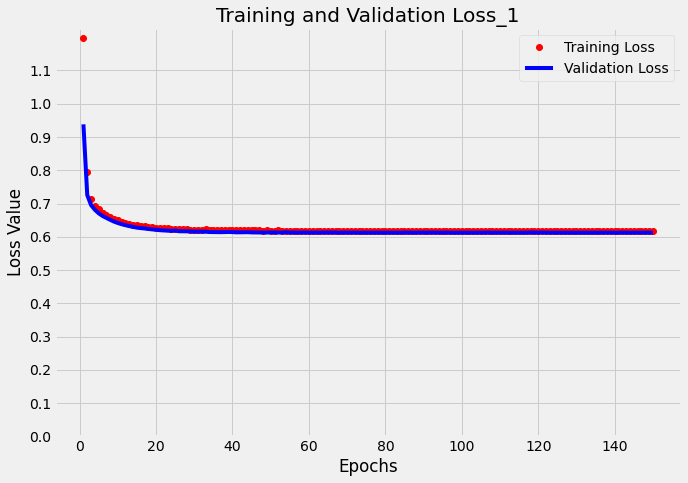

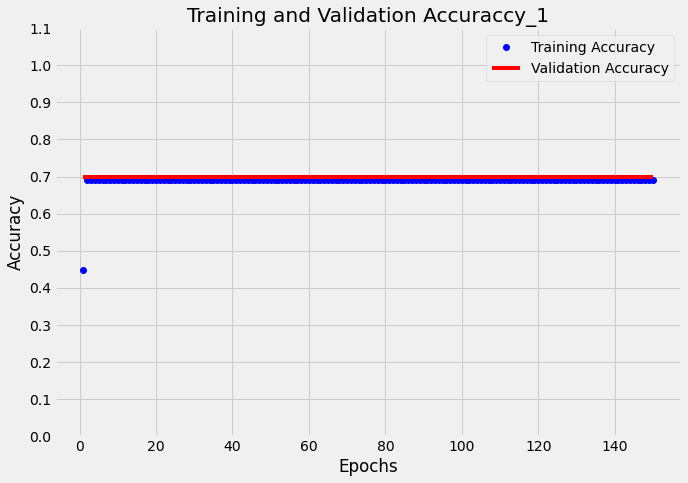

16/16 [==============================] - 0s 1ms/step - loss: 0.6914 - accuracy: 0.6020
{'loss': [0.6913700103759766], 'accuracy': [0.6019999980926514], 'true_classes': [array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)], 'pred_classes': [array([2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2,
       1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1,
       1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2], dtype=int64)], 'load': [115    13
477     2
163     6
281     3
447     2
       ..
31      3
431     7
364     5
355     4
341

In [86]:

# holds test data evaluation and predicted belt tension class 
cashe ={} # printing Average Loss and Accuracy

# reading trainiing data file
df_train= pd.read_csv("traningData_349.csv")
df_train=df_train.loc[(df_train['%Belt Tension']==85) | (df_train['%Belt Tension']==75)] 
T_class = 1
epocs = 150
features= ['Normalized_Power','Normalized_Belt_Tension']#,'Normalized_Load'

# list contains number of hidden and output layer nodes
model_architecture = [10,10,6,3]
#if isinstance(split.get("TT_split"),tuple):
    
# build and compile model
model = NN_model(model_architecture)
    
"""
    For loop for getting average loss and accuracy
"""
for i in range(1):

    # spliting the data into train-test data 
    print(f'Splitting data {i+1}.\n')

    split = train_test(df_train,features)
    #X_train, X_test, y_train, y_test= split.get("TT_split")
    if isinstance(split.get("TT_split"),tuple):
        # fit model
        history = fit_model(model,split,i+1,epocs)

        # getting loss and accuracy for training and validation data
        history_dict = history.history
        print(history_dict.keys())

        # Plotting losses 
        plot_loss(history_dict,i+1)

        # Training and Validation Accuracy
        plot_accuracy(history_dict,i+1)

        res = prdict_Tension_class(model,i+1,features,T_class)


        if f'class_{T_class}' not in cashe:

            cashe[f'class_{T_class}'] = dict(
                            [('loss',[res[1]]), ('accuracy',[res[2]]),
                            ('true_classes',[res[3]]),('pred_classes', [res[4]]),
                             ('load',[res[5]]),('power',[res[6]])]
                             )
        else:
            temp = cashe.get(f'class_{T_class}')
            temp['loss'].append(res[1])
            temp['accuracy'].append(res[2])
            temp['true_classes'].append(res[3])
            temp['pred_classes'].append(res[4])
            temp['load'].append(res[5])
            temp['power'].append(res[6])
            #(T_class,results[0],results[1],True_label,pred,load,power)
    
    else:
        print(split.get("TT_split"))
        #print(prdict_Tension_class(1))
        
print(cashe.get(f'class_{T_class}'))

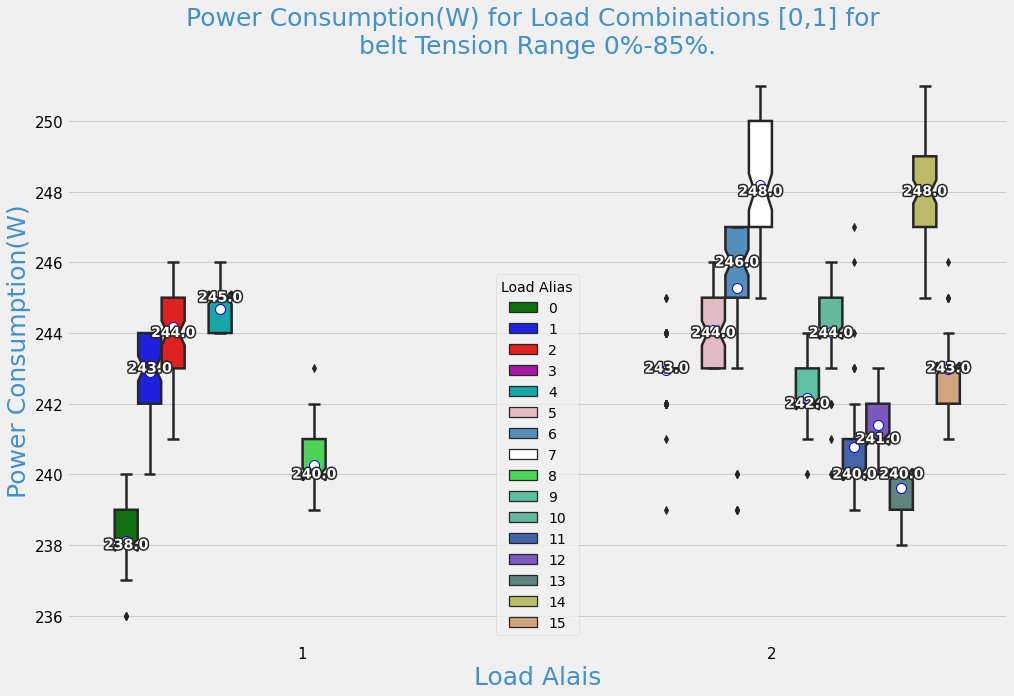

In [61]:


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
df_train= pd.read_csv("traningData_349.csv")
#plt.yticks(np.arange(210,246,2))
plt.figure(figsize =(15.0,10.0))
def add_median_labels(ax):
    lines = ax.get_lines()
    # determine number of lines per box (this varies with/without fliers)
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    # iterate over median lines
    for median in lines[4:len(lines):lines_per_box]:
        # display median value at center of median line
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1]-median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:.1f}', ha='center', va='center',
                       fontweight='bold', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])


        
# df_0 = df_L.loc[df_L['%Belt Tension']==0]
# df_15 = df_L.loc[df_L['%Belt Tension']==15]
# df_30 = df_L.loc[df_L['%Belt Tension']==30]
# df_45 = df_L.loc[df_L['%Belt Tension']==45]
# df_60 = df_L.loc[df_L['%Belt Tension']==60]
# df_70 = df_L.loc[df_L['%Belt Tension']==70]
#df_75 = df_L.loc[(df_L['%Belt Tension']==75) & (df_L['Load Alias']==0)] 
df_85 = df_train.loc[(df_train['%Belt Tension']==85)]# | (df_train['%Belt Tension']==75)] 

#df_concat = pd.concat((df_0, df_15,df_30,df_45,df_60,df_70,df_75,df_85))

my_pal = {
            0: "g", 1: "b", 2:"r", 3:"m", 4:"c", 5:"#e8b5c2",6:'#4390cb',7:'w',
            8: "#34eb46", 9: "#4dd1a7", 10:"#56c7a3", 11:"#355cb8", 12:"#7349cc", 13:"#588a82",14:'#c8c95d',15:'#dba572'
         }
box_plot=sns.boxplot(y=df_85['Power (W)'], x=df_85['Load1'],#df['%Belt Tension'], 
                 data=df_85,
                 hue=df_85['Load Alias'],
           #palette = 'husl',
             palette=my_pal,
             showfliers=True,
             linewidth=2.5,
            notch=True,
            showmeans=True,
                     width=0.8,
             meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"blue","markersize":"10"})
box_plot.set_xlabel("Load Alais",fontsize=25,color='#4390cb')
box_plot.set_ylabel("Power Consumption(W)",fontsize=25,color='#4390cb')
box_plot.set_title("Power Consumption(W) for Load Combinations [0,1] for \nbelt Tension Range 0%-85%.",fontsize=25,color='#4390cb')
#plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
#plt.setp(ax.get_legend().get_title(), fontsize='20') # for legend title
# box_plot.set_yticklabels(b.get_yticks(), size = 20)
# box_plot.set_xticklabels(b.get_xticks(), size = 20)
box_plot.tick_params(labelsize=15)        
#box_plot = sns.boxplot(x="day", y="total_bill", data=tips, showfliers=False, hue="sex")
add_median_labels(box_plot.axes)
plt.show()

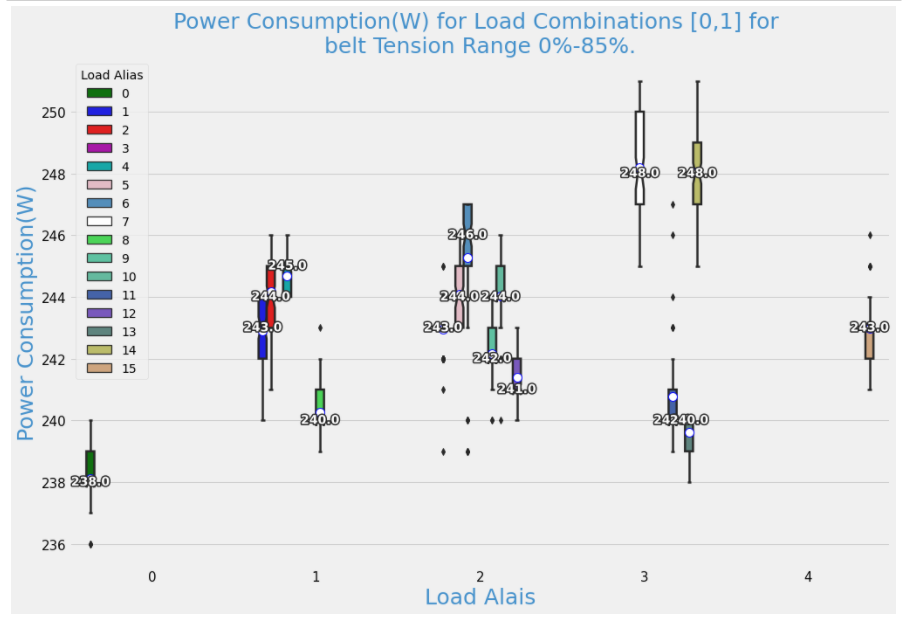

In [50]:
df_train= pd.read_csv("traningData_349.csv")
df_train=df_train.loc[(df_train['%Belt Tension']==85) | (df_train['%Belt Tension']==75)] 

In [59]:
choices=[1,1,1,1,1,
         2,2,2,2,2,2,
         2,2,2,2,
        2] #[1,1,1,1,1,1,1,2,3,4],[1,1,1,1,1,1,1,2,2,3]
conditions= [
            df['Load Alias'].eq(0),
            df['Load Alias'].eq(1),df['Load Alias'].eq(2),df['Load Alias'].eq(4),df['Load Alias'].eq(8),

            df['Load Alias'].eq(3),df['Load Alias'].eq(5),df['Load Alias'].eq(6),df['Load Alias'].eq(9),
            df['Load Alias'].eq(10),df['Load Alias'].eq(12),

            df['Load Alias'].eq(7),df['Load Alias'].eq(11),
            df['Load Alias'].eq(13),df['Load Alias'].eq(14),
    
            df['Load Alias'].eq(15)
            ]
df['Load1'] = np.select(conditions, choices, default= df['Load Alias'])

df.to_csv('s_Measurements10.csv',index=False)
df= pd.read_csv("s_Measurements10.csv")